
FC_NET_1_1_1_1

Forward ended


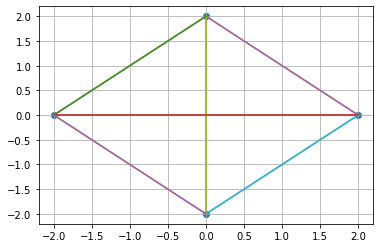

Forward ended


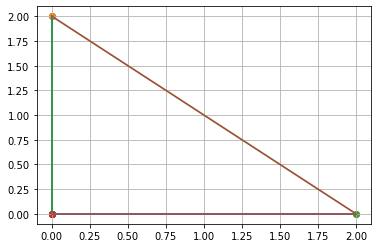

Forward ended


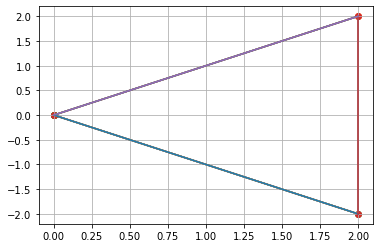

Forward ended


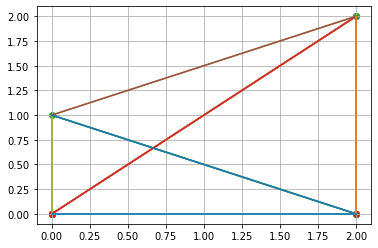

Forward ended


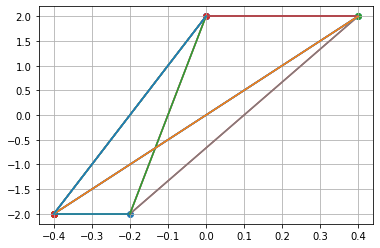

Index 0, NumStar: 8
Index 1, NumStar: 56
Index 0, NumStar: 4
Index 1, NumStar: 16
Index 0, NumStar: 8
Index 1, NumStar: 36
Index 0, NumStar: 4
Index 1, NumStar: 16
Forward ended


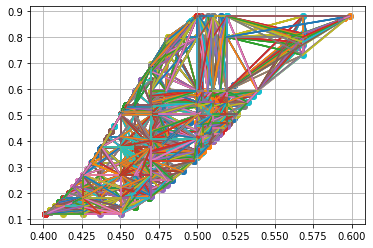

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pypoman
import scipy.spatial

import pynever.strategies.abstraction as abst
import pynever.nodes as nodes


def plot_starset(p_starset: abst.StarSet):
    for p_star in p_starset.stars:

        alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
        x_vertexes = []
        for v in alpha_vertexes:
            v_ver = np.zeros((v.shape[0], 1))
            for k in range(v.shape[0]):
                v_ver[k, 0] = v[k]
            new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
            x_vertexes.append(new_x_v)

        x1_plot = []
        x2_plot = []
        for v in x_vertexes:
            x1_plot.append(v[0, 0])
            x2_plot.append(v[1, 0])

        for k in range(len(x1_plot)):
            for j in range(len(x1_plot)):
                plt.plot([x1_plot[k], x1_plot[j]], [x2_plot[k], x2_plot[j]])

        plt.scatter(x1_plot, x2_plot)
        # plt.fill_between(x1_plot, x2_plot)

    plt.grid()
    plt.show()


def get_extreme_points(p_starset: abst.StarSet):
    x_vertexes = []
    for p_star in p_starset.stars:
        alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
        for v in alpha_vertexes:
            v_ver = np.zeros((v.shape[0], 1))
            for k in range(v.shape[0]):
                v_ver[k, 0] = v[k]
            new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
            new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
            x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)
    return x_vertexes


def plot_convex_hull(points: np.ndarray):
    hull = scipy.spatial.ConvexHull(points)
    vertexes = points[hull.vertices, :]
    vertexes = np.vstack((vertexes, vertexes[0, :]))
    plt.plot(vertexes[:, 0], vertexes[:, 1])
    plt.grid()
    plt.show()


# Bidimensional Example with abstract verification

weight_matrix_1 = np.ones((2, 2))
weight_matrix_2 = np.ones((2, 2))
# weight_matrix_3 = np.ones((2, 2))
weight_matrix_3 = np.zeros((2, 2))

weight_matrix_1[1, 1] = -1
weight_matrix_2[1, 1] = -1
# weight_matrix_3[0, 1] = 0
weight_matrix_3[0, 0] = 1.0 / 5.0
weight_matrix_3[0, 1] = 1.0 / 5.0
weight_matrix_3[1, 0] = 2

bias_1 = np.zeros([2, 1])
bias_2 = np.zeros([2, 1])
bias_3 = np.zeros([2, 1])
bias_3[0, 0] = - 0.4
bias_3[1, 0] = - 2


net_names = ["FC_NET_1_1_1_1"]

neuron_relevance = True
refinement_percentage = 1

final_hulls = []
for i in range(len(net_names)):

    print("\n" + net_names[i] + "\n")

    abs_net = abst.AbsSeqNetwork(net_names[i])

    abs_net.add_node(
        abst.AbsFullyConnectedNode("AbsFC_1", nodes.FullyConnectedNode("FC_1", 2, 2, weight_matrix_1, bias_1)))

    abs_net.add_node(abst.AbsReLUNode("AbsReLU_1", nodes.ReLUNode("ReLU_1", 2), neuron_relevance=neuron_relevance,
                                      refinement_percentage=refinement_percentage))
    abs_net.add_node(
        abst.AbsFullyConnectedNode("AbsFC_2", nodes.FullyConnectedNode("FC_2", 2, 2, weight_matrix_2, bias_2)))

    abs_net.add_node(abst.AbsReLUNode("AbsReLU_2", nodes.ReLUNode("ReLU_2", 2), neuron_relevance,
                                      refinement_percentage))

    abs_net.add_node(
        abst.AbsFullyConnectedNode("AbsFC_3", nodes.FullyConnectedNode("FC_3", 2, 2, weight_matrix_3, bias_3)))

    abs_net.add_node(abst.AbsSigmoidNode("AbsSig_1", nodes.SigmoidNode("Sig_1", 2), approx_levels=2))

    C = np.zeros((4, 2))
    C[0, 0] = 1
    C[1, 0] = -1
    C[2, 1] = 1
    C[3, 1] = -1

    d = np.ones((4, 1))
    d[0, 0] = 1
    d[1, 0] = 1
    d[2, 0] = 1
    d[3, 0] = 1

    star = abst.Star(C, d)
    abs_input = abst.StarSet({star})
    current_node = abs_net.get_first_node()
    aux_points = get_extreme_points(abs_input)
    # plot_convex_hull(aux_points)
    while current_node is not None:
        print(current_node)
        abs_input = current_node.forward(abs_input)
        print("Forward ended")
        #aux_points = get_extreme_points(abs_input)
        plot_starset(abs_input)
        #plot_convex_hull(aux_points)
        current_node = abs_net.get_next_node(current_node)